# EPM Analysis
### Requires MossyEPM struct containing cell activity and behavior matrices for each mouse. Behavior is 30 fps, cell activity is 20 fps for drd73, drd77 and 10 fps for drd87, drd46

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from pandas.plotting import radviz
import Core

style.use('seaborn')

%matplotlib inline

In [3]:
data = pd.read_csv('~/TraceRaw_Mouse_drd46.csv', header=None)
lst_of_dataframes = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
AUC_dataframe = lst_of_dataframes[1]
# AUC_dataframe

# lst_of_dataframes[0].plot(subplots=True, figsize=(20, 20));
# lst_of_dataframes[1].plot(subplots=True, figsize=(20, 20));
# lst_of_dataframes[2].plot(subplots=True, figsize=(20, 20));

In [4]:
behavior_column_names = ['Trial time', 'Recording time', 'X center', 'Y center', 'Area', 'Areachange', 
                         'Elongation', 'Distance moved', 'Velocity', 'In zone(Arena / center-point)',
                         'In zone(Open1 / center-point)', 'In zone(Open2 / center-point)',
                         'In zone(Closed1 / center-point)', 'In zone(Closed2 / center-point)',
                         'In zone(OpenArms / center-point)', 'In zone(ClosedArms / center-point)', 'Result 1']

activity_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/activity_drd46.csv', header=None)
behavior_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/behavior_drd46.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

"""
activity = EPM_activity.(mice{i});
behavior = EPM_behavior_ds.(mice{i});

# Rates for entire session
[AUCrates.(mice{i}), ~] = mc_epm_calc_beh_rates(behavior, activity, 'EPM');
AUCrates.(mice{i}) = 10 * AUCrates.(mice{i});

# AUCrates_binned = NaN;

bin_length = floor(size(activity, 1) / time_bin_factor);

for j = in range(0, TIME_BIN_FACTOR):
    start_frame = (j - 1) * bin_length + 1;
    end_frame = j * bin_length;
    [AUCrates_binned.(mice{i}){j}, AUCtotal_binned.(mice{i}){j}] = mc_epm_calc_beh_rates(behavior(start_frame:end_frame, :), activity(start_frame:end_frame, :), 'EPM');  

    # Multiply by frame rate to get rate in seconds
    AUCrates_binned.(mice{i}){j} = 10 * AUCrates_binned.(mice{i}){j}; 
    
    # Divide by bin_length to get total average total rate per bin
    # AUCtotal_binned.(mice{i}){j} = 10*AUCtotal_binned.(mice{i}){j} / bin_length;
    
    AUCtotal_binned_rate.(mice{i}){j} = 10 * sum(AUCtotal_binned.(mice{i}){j}(:, 1:3), 2) / bin_length; 

# AUCtotal_binned_rate.(mice{i}) = cell2mat(AUCtotal_binned_rate.(mice{i}));

# Create array with all cells by behavior over the whole session 
for i = 1:numel(mice)
    if i == 1:
        AUC_all_cells = AUCrates.(mice{i});
    else:
        AUC_all_cells = [AUC_all_cells; AUCrates.(mice{i})]

# Create array with all neurons for each time bin, irrespective of behavior
for i = 1:numel(mice):
    if i == 1:
        AUC_bin_all_cells = AUCtotal_binned_rate.(mice{i})
    else:
        AUC_bin_all_cells = [AUC_bin_all_cells; AUCtotal_binned_rate.(mice{i})]

# Calculate time bin averages and SEM per animal
for i = 1:numel(mice):
    AUC_all_cells_binned = AUCrates.rates_binned.(mice{i});
    AUC_bin_means(i,:) = mean(AUCtotal_binned_rate.(mice{i}));
    AUC_bin_SE(i,:) = std(AUCtotal_binned_rate.(mice{i}))/sqrt(size(AUCrates.(mice{i}),1));

# Store 10 col. averages per time bin (Nbins x 10)
for i = 1:numel(mice):
    for j in range(0, TIME_BIN_FACTOR):
        sum_closed(j) = sum_closed(j) + sum(AUCrates_binned.(mice{i}){j}(1), 2);
        sum_open(j) = sum_open(j) + sum(AUCrates_binned.(mice{i}){j}(2), 2);    
"""

# *** TEST ***
# activity_df
behavior_df
AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([AUC_dataframe, behavior_df], axis=1)
# result_dataframe

In [5]:
def activity_by_neuron(dataframe, neuron, behavior):
    sum_of_neuron_values = sum([dataframe[neuron][i] for i in range(0, len(dataframe[neuron])) if dataframe[behavior][i] != 0])
    amount_of_ones = len([value for value in dataframe[behavior] if value == 1])
    return 10 * sum_of_neuron_values / amount_of_ones 

In [6]:
activity_by_neuron(result_dataframe, 'neuron6', 'In zone(OpenArms / center-point)')

0.75027020368342978

In [7]:
def load_Activities_DataFrame(dataframe):
    
    activities_dict = {}
    behaviors = ['In zone(Arena / center-point)', 'In zone(Open1 / center-point)', 'In zone(Open2 / center-point)',
                 'In zone(Closed1 / center-point)', 'In zone(Closed2 / center-point)',
                 'In zone(OpenArms / center-point)', 'In zone(ClosedArms / center-point)']

    activities_dataframe = pd.DataFrame(index=AUC_dataframe.columns)

    for behavior in behaviors:
        for neuron in AUC_dataframe:
            activities_dict[neuron] = (activity_by_neuron(dataframe, neuron, behavior))

        activities_dataframe[behavior] = pd.Series(activities_dict)

    return activities_dataframe

In [8]:
experiment = load_Activities_DataFrame(result_dataframe)
experiment

,In zone(Arena / center-point),In zone(Open1 / center-point),In zone(Open2 / center-point),In zone(Closed1 / center-point),In zone(Closed2 / center-point),In zone(OpenArms / center-point),In zone(ClosedArms / center-point)
neuron1,1.576410,2.645694,0.000000,1.594418,0.000000,1.225641,1.441399
neuron2,2.550079,0.000000,6.111075,2.533474,0.000000,3.280066,2.290333
neuron3,1.298110,0.000000,0.409119,1.602695,1.894226,0.219591,1.630674
neuron4,0.833156,0.374413,0.000000,1.013149,0.000000,0.173450,0.915916
neuron5,1.606254,0.000000,1.158226,1.982304,0.000000,0.621667,1.792059
neuron6,1.229153,0.519223,0.949686,1.341946,0.187021,0.750270,1.231106
neuron7,2.242812,4.320868,7.649587,1.868316,0.000000,6.107529,1.689011
neuron8,2.338661,0.000000,3.403959,2.764084,0.425555,1.827045,2.539652
neuron9,2.992903,2.355366,1.874975,3.028252,5.764536,1.839239,3.258929
neuron10,1.864335,0.000000,0.212816,2.095979,2.778269,0.114227,2.161460


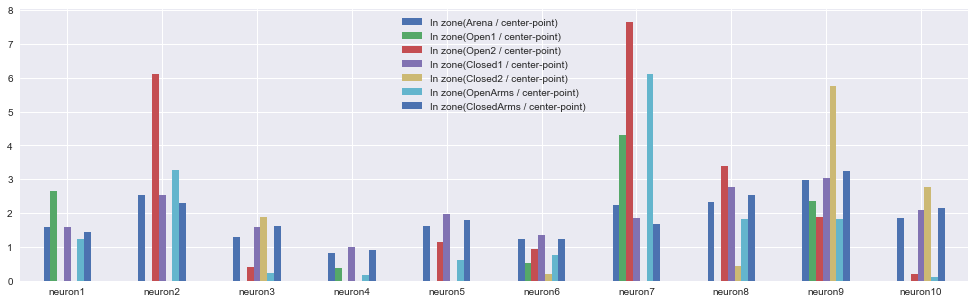

In [9]:
experiment.plot.bar(figsize=(17, 5), rot=0);

In [10]:
# result_dataframe.plot.scatter(x='Trial time', y='neuron7');
neuron7_list = list()
for i in range(0, result_dataframe['neuron7'].size):
    if result_dataframe['In zone(Open2 / center-point)'][i] != 0:
        neuron7_list.append(result_dataframe['neuron7'][i])
    else:
        neuron7_list.append(np.nan)
        
# neuron7_dataframe = result_dataframe[['Trial time']].copy()
# neuron7_dataframe['neuron7'] = pd.Series(neuron7_list)
# neuron7_dataframe['neuron7'][neuron7_dataframe['neuron7'] > 0]
# neuron7_dataframe['neuron7'] = pd.DataFrame(columns=[n]neuron7_list)
# sns.regplot(x=result_dataframe['Trial time'], y=neuron7_dataframe['neuron7'], color="g");

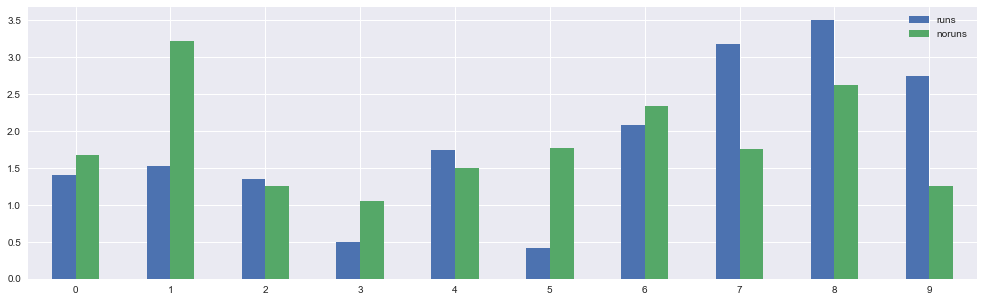

In [11]:
run_vector = behavior_df['Running frames'][behavior_df['Running frames'] != 0].index.tolist()
no_run_vector = behavior_df['Running frames'][behavior_df['Running frames'] == 0].index.tolist()

run_sums = [activity_df[column][run_vector].sum() for column in activity_df]
no_run_sums = [activity_df[column][no_run_vector].sum() for column in activity_df]   

# TODO: Get rid of magic number, 10, and utilize FRAME_RATE
run_sums1 = [10 * run_sums[i] / len(run_vector) for i in range(0, len(run_sums))]
no_run_sums1 = [10 * no_run_sums[i] / len(no_run_vector) for i in range(0, len(no_run_sums))]

run_noruns_dataframe = pd.DataFrame(columns=['runs', 'noruns'])
run_noruns_dataframe['runs'] = pd.Series(run_sums1)
run_noruns_dataframe['noruns'] = pd.Series(no_run_sums1)
run_noruns_dataframe.plot.bar(figsize=(17, 5), rot=0);

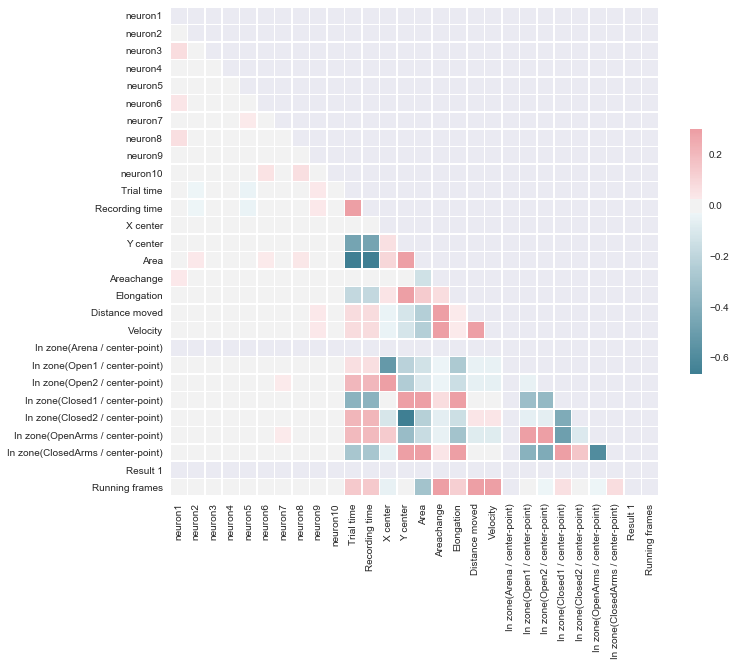

In [12]:
# Compute the correlation matrix
corr = result_dataframe.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});